## 1. Preparing the Data

In [1]:
import pandas as pd
print("packages imported well")

packages imported well


In [3]:
# Load the dataset
data = pd.read_csv('machine_failure_data.csv')
# Display basic information
print(data.info())
print(data.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Machine_ID   1000 non-null   object
 1   Usage_Hours  1000 non-null   int64 
 2   Failures     1000 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 23.6+ KB
None
  Machine_ID  Usage_Hours  Failures
0  Machine_1          910         0
1  Machine_2         3822         1
2  Machine_3         3142         1
3  Machine_4          516         0
4  Machine_5         4476         1


## 2. Categorizing Data for ANOVA/MANOVA

#### a. Creating Failure Groups

In [4]:
# Create a categorical variable for failure status
data['Failure_Status'] = data['Failures'].apply(lambda x: 'No Failure' if x == 0 else 'Failure')


#### b.Categorizing Usage Hours

In [5]:
# Define usage hour bins
bins = [0, 1000, 3000, 5000]
labels = ['Low Usage', 'Medium Usage', 'High Usage']
data['Usage_Category'] = pd.cut(data['Usage_Hours'], bins=bins, labels=labels)


## 3. Applying ANOVA

#### a. Comparing Usage_Hours Between Failure Groups

In [7]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Define the model
model = ols('Usage_Hours ~ C(Failure_Status)', data=data).fit()

# Perform ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)


                         sum_sq     df          F    PR(>F)
C(Failure_Status)  3.364828e+07    1.0  17.681755  0.000028
Residual           1.899188e+09  998.0        NaN       NaN


#### b. Comparing Failures Across Different Usage Categories

In [8]:
# Define the model
model = ols('Failures ~ C(Usage_Category)', data=data).fit()

# Perform ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)


                       sum_sq     df         F    PR(>F)
C(Usage_Category)    4.117851    2.0  8.366507  0.000249
Residual           245.353149  997.0       NaN       NaN


## 4. Applying MANOVA

In [9]:
from statsmodels.multivariate.manova import MANOVA

# Define the MANOVA model
maov = MANOVA.from_formula('Usage_Hours + Failures ~ Failure_Status', data=data)
print(maov.mv_test())


                                  Multivariate linear model
                                                                                             
---------------------------------------------------------------------------------------------
       Intercept                Value         Num DF  Den DF          F Value          Pr > F
---------------------------------------------------------------------------------------------
          Wilks' lambda                0.0000 2.0000 997.0000 1122522207122095616.0000 0.0000
         Pillai's trace                1.0000 2.0000 997.0000 1122522207122095616.0000 0.0000
 Hotelling-Lawley trace 2251799813685247.0000 2.0000 997.0000 1122522207122095488.0000 0.0000
    Roy's greatest root 2251799813685247.0000 2.0000 997.0000 1122522207122095616.0000 0.0000
---------------------------------------------------------------------------------------------
                                                                                             


In [10]:
#  Summary Statistics for Usage_Hours and Failures
print(data[['Usage_Hours', 'Failures']].describe())


       Usage_Hours     Failures
count  1000.000000  1000.000000
mean   2578.250000     0.523000
std    1390.960625     0.499721
min      53.000000     0.000000
25%    1389.500000     0.000000
50%    2647.000000     1.000000
75%    3693.250000     1.000000
max    4998.000000     1.000000


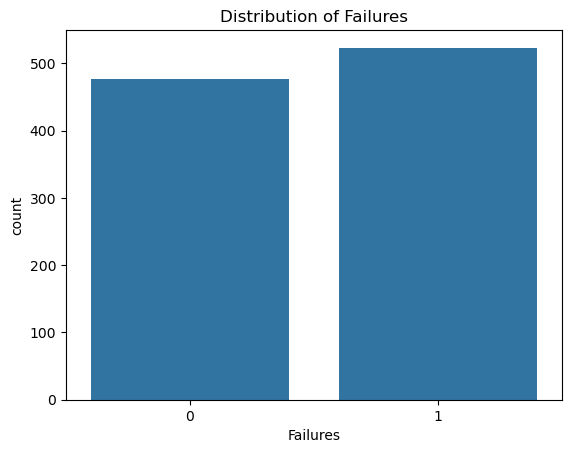

In [11]:
# Distribution of Failures Among Machines
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='Failures', data=data)
plt.title('Distribution of Failures')
plt.show()


In [12]:
# Machines with Highest and Lowest Usage_Hours
# Highest Usage Hours
highest_usage = data.nlargest(5, 'Usage_Hours')
print("Machines with Highest Usage Hours:")
print(highest_usage[['Machine_ID', 'Usage_Hours']])

# Lowest Usage Hours
lowest_usage = data.nsmallest(5, 'Usage_Hours')
print("\nMachines with Lowest Usage Hours:")
print(lowest_usage[['Machine_ID', 'Usage_Hours']])


Machines with Highest Usage Hours:
      Machine_ID  Usage_Hours
619  Machine_620         4998
489  Machine_490         4996
347  Machine_348         4983
173  Machine_174         4981
335  Machine_336         4979

Machines with Lowest Usage Hours:
      Machine_ID  Usage_Hours
810  Machine_811           53
353  Machine_354           54
807  Machine_808           55
610  Machine_611           59
837  Machine_838           59


In [13]:
# Correlation Between Usage_Hours and Failures
correlation = data['Usage_Hours'].corr(data['Failures'])
print(f"Correlation between Usage_Hours and Failures: {correlation}")


Correlation between Usage_Hours and Failures: 0.1319422416497868


In [14]:
# Number of Machines with Zero Failures
zero_failures = data[data['Failures'] == 0]
print(f"Number of machines with zero failures: {zero_failures.shape[0]}")


Number of machines with zero failures: 477


In [15]:
# Patterns Between Usage_Hours and Failures for Prediction
import statsmodels.api as sm

# Define independent and dependent variables
X = data['Usage_Hours']
y = data['Failures']

# Add constant to the model
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               Failures   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     17.68
Date:                Sat, 23 Nov 2024   Prob (F-statistic):           2.85e-05
Time:                        13:01:05   Log-Likelihood:                -715.95
No. Observations:                1000   AIC:                             1436.
Df Residuals:                     998   BIC:                             1446.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.4008      0.033     12.138      